## Gate Cutting to Reduce Circuit Width

In this tutorial we will simulate expectation values of a four-qubit circuit using only two-qubit experiments by cutting gates in the circuit.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **cut** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments on the backend(s)
- **reconstruct** the simulated expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting.cutting import (
    partition_problem,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to cut

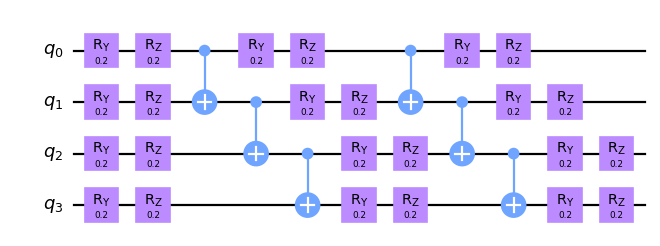

In [2]:
circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.2] * len(circuit.parameters), inplace=True)

circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.3.0.

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Separate the circuit and observables according to a specified qubit partitioning

Each label in `partition_labels` corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [4]:
subcircuits, cuts, subobservables = partition_problem(
    circuit=circuit, partition_labels="AABB", observables=observables
)

`partition_problem` returns:

- `Dict` mapping partition labels to subcircuits
- `List` containing the decomposition and location information for each cut
- `Dict` mapping partition labels to subobservables

### Visualize the decomposed problem

In [5]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

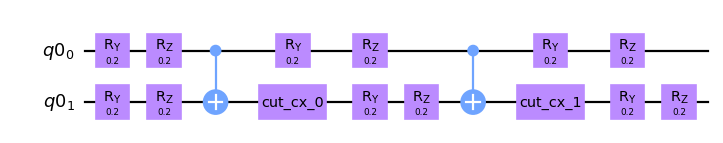

In [6]:
subcircuits["A"].draw("mpl", scale=0.8)

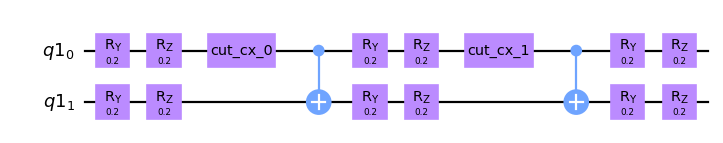

In [7]:
subcircuits["B"].draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

The sampling overhead is the factor by which the number of samples must increase for the quasiprobability decomposition to result in the same amount of error, $\epsilon$, as one would get by sampling the original circuit. Cutting CNOT and CZ gates incurs a sampling overhead of roughly $O(9^k/\epsilon^2)$, where $k$ is the number of cuts [[Mitarai, Fujii]](https://arxiv.org/abs/1909.07534); however, other gates may have higher or lower exponential bases. For example, the sampling overhead resulting from cutting SWAP gates scales with complexity $O(49^k/\epsilon^2)$ [[Mitarai, Fujii]](https://arxiv.org/abs/2006.11174).

Here we cut two CNOT gates, resulting in a sampling overhead of $9^2$.

In [8]:
bases = [cut.basis for cut in cuts]
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


### Generate and run the cutting experiments

`execute_experiments` accepts `circuits`/`subobservables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends.

The number of weights taken from the distribution is controlled by `num_samples`. Each weight whose absolute value is above a threshold of 1 / `num_samples` will be evaluated exactly.  The remaining low-probability elements -- those in the tail of the distribution -- will then be sampled from, resulting in at most `num_samples` unique weights.

Much of the circuit cutting literature describes a process where we sample from the distribution, take a single shot, then sample from the distribution again and repeat; however, this is not feasible in practice. The total number of shots needed grows exponentially with the number of cuts, and taking single shot experiments via Qiskit Runtime quickly becomes untenable. Instead, we take an equivalent number of shots for each considered subexperiment and send them to the backend(s) in batches. During reconstruction, each subexperiment contributes to the final result with proportion equal to its weight.  We just need to ensure the number of shots we take is appropriate for the heaviest weights, and thus, appropriate for all weights.

In [9]:
# Keep in mind, Terra Sampler does not support mid-circuit measurements at all,
# and Aer Sampler does not support mid-circuit measurements when shots==None.
samplers = {
    "A": Sampler(run_options={"shots": 2**12}),
    "B": Sampler(run_options={"shots": 2**12}),
}

quasi_dists, coefficients = execute_experiments(
    circuits=subcircuits,
    subobservables=subobservables,
    num_samples=50,
    samplers=samplers,
)

`execute_experiments` returns:

- A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment
- The coefficients for each subexperiment

### Reconstruct the simulated expectation values
`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape (`num_unique_samples`, `num_partitions`, `num_commuting_observ_groups`), and `coefficients` is a list with length equal to the number of unique samples. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s), as output from `decompose_problem` above.

In [10]:
simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    subobservables,
)

The output of `reconstruct_expectation_values` is a list of simulated expectation values -- one for each observable.

### Compare the simulated expectation values with the exact expectation values from the original circuit

In [11]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Simulated expectation values: {[np.round(simulated_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(simulated_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((simulated_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [0.74385685, 0.83981293, 0.85681641, 0.19941306, 0.7699222, 0.12753934]
Exact expectation values: [0.75617717, 0.84065011, 0.88047906, 0.20063312, 0.74926376, 0.12404645]
Errors in estimation: [-0.01232032, -0.00083717, -0.02366265, -0.00122005, 0.02065844, 0.00349288]
Relative errors in estimation: [-0.01629291, -0.00099586, -0.02687475, -0.00608102, 0.02757165, 0.02815787]
